In [29]:
# ---------------------------------------------------------------------------
# Notebook: Marketing ICP generation with clustering
# Unsupervised Algorithms applications
#
# (©) 2022 Juan Antonio Cabeza Sousa, Spain
# email juaancabsou@gmail.com
# ---------------------------------------------------------------------------

In [30]:
# Libraries
import sys
sys.path.append("C:/Users/Juan/Documents/GitHub/medium")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from etl01_basics import *

# Introduction

Marketing has a critical role when it comes to feed the company with customers that are aligned with the product or service that such company is offering. In order to do that properly it is important to understand your target audience generating different ICPs or Ideal Customer Profiles.

> An ideal customer profile (ICP) is an attribute-description of the type of customer that fits better to your company strategy.

Customer Segmentation or Customer Personality Analysis is about creating different groups or segment of customers based on their behaviors. This segmentation aims to help businesses to understand their customers allowing them to:

- Identify pain points and concerns in customers
- Modify products and behaviors to specific needs
- Improve marketing campaigns and targeting

**The goal of this notebook**

This notebook aims to classify the different customers from *marketing_campaign.csv* in different segments with the goal of improving marketing campaigns in the future.

## The data


In [31]:
PATH = "C:/Users/Juan/Documents/GitHub/medium/"
PATH_DATA = PATH + "/data/"
data = read_data(PATH_DATA, "marketing_campaign.csv")

In [32]:
quickstats_df(data)

Shape: (2240, 29)
Duplicates:  0 -> 0.0 %


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,ID,0,2240,100.00,2240
1,Year_Birth,0,2240,100.00,59
2,Education,0,2240,100.00,5
3,Marital_Status,0,2240,100.00,8
4,Income,24,2216,98.93,1974
5,Kidhome,0,2240,100.00,3
6,Teenhome,0,2240,100.00,3
7,Dt_Customer,0,2240,100.00,663
8,Recency,0,2240,100.00,100
9,MntWines,0,2240,100.00,776


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,False,False,False,False,False,False,3,11,True
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,False,False,False,False,False,False,3,11,False
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,False,False,False,False,False,False,3,11,False
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,False,False,False,False,False,False,3,11,False
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,False,False,False,False,False,False,3,11,False


# 2. Exploratory Data Analysis

This stage covers the first analysis of the data. The goal of this is to understand better the initial data that we have and doing an initial cleaning like filling empty values, removing outliers, drop useless information...so on so forth.

As a first steps, it is possible to see that:
- We don"t have the age of the user, instead we have the `YearBirth`
- Column `Dt_Customer` is not parsed as DateTime. Also, this column represents the date of customer"s enrollment with the company but we don"t have as a number the seniority of a client. We"ll let that to the feature engineering stage
- Column `Income` has 1.07% of empty values. As this percentage represents just 24 instances at the moment, we"ll remove it for now.
- We have several columns with categorical information. We need to check the proportion of those categories and also to encode them as numeric.
    - Education is quite specific currently so we"ll create just 3 categories in order to simplify the data.
    - In this case, it is possible to see that there are a few values in `Marital_State` column that should be categorised as *Alone*. Also the idea is to simplify categories here. 

In [33]:
# Clean datetime
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")
# For this research I will remove the 1% of NAs that we have
data.dropna(inplace=True)

In [34]:
# Clean Marital Status
data["Education"] = data["Education"].apply(lambda x: "NoGraduate" if x in ["Basic", "2n Cycle"] else "Graduate")
data["Marital_Status"] = data["Marital_Status"].apply(lambda x: "Alone" if x in ["Single", "Absurd", "YOLO", "Widow"] else ("Partner" if x in ["Married", "Together"] else x))

display(pd_categories_trans(data, "Education"))
display(pd_categories_trans(data, "Marital_Status"))

index,Graduate,NoGraduate
Education,1962,254


index,Partner,Alone,Divorced
Marital_Status,1430,554,232


# 3. Data Preprocessing
## 3.1 - Feature Engineering

After have cleaned the data, we can focus on generating new features about these customers. In order to do that, we will:

- Create new feature `Age` from the `Year_Birth` column.
- Create new feature `Seniority` from the `Dt_customer`.
- Create new feature `Partner` in order to replace `Marital_Status`. We just want to know if the customer has a partner or not.
- Create new feature `Children` for replacing `Kidhome` and `Teenhome`
- Create new feature `FamilySize` in order to know how many people live with the client.
- Create new feature `IsParent` from previous feature.
- Create new feature `Bill` as the summatory of amounts spent by the customer in the different categories over the 2 years.

In [35]:
# Extract Age from the Year (The data was created in 2021)
data["Age"] = 2021 - data["Year_Birth"]

# In order to calculate the seniority, use the max date in the database as last record
max_record = max(data["Dt_Customer"])
data["Seniority"] = (max_record - data["Dt_Customer"]).dt.days


# Family Features
data["Partner"] = data["Marital_Status"].apply(lambda x: 1 if x =="Partner" else 0)
data["Children"] = data["Kidhome"] + data["Teenhome"]
data["FamilySize"] = data["Children"]+data["Partner"] + 1
data["IsParent"] = data["Children"].apply(lambda x: 1 if x>=1 else 0)

# Bill feature
data["Bill"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

In [36]:
# Drop Useless columns
billcols = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
mkt_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5']
othercols = ['Complain', 'Response']

data.drop([
    "Dt_Customer",
    "Marital_Status",
    "Z_CostContact",
    "Z_Revenue",
    "Year_Birth",
    "Kidhome",
    "Teenhome",
    "ID"
], axis=1, inplace=True)

data.drop(billcols, axis=1, inplace=True)
data.drop(othercols, axis=1, inplace=True)

## 3.2 Data Checking
Once that we have finished generating features it is time to check the final dataset information. In order to do that, I usually check the data with 3 different approaches:
1. Data completion: How many empty values do we have after the feature engineering?
2. Data outliers: How many outliers do we have? And of course, fixing the outliers as well
3. Data coherence: Does each feature contain coherent with the rest of the dataset?

In [37]:
data.describe()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Seniority,Partner,Children,FamilySize,IsParent,Bill
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,49.012635,2.323556,4.085289,2.671029,5.800993,5.319043,52.179603,353.521209,0.645307,0.947202,2.592509,0.714350,607.075361
std,25173.076661,28.948352,1.923716,2.740951,2.926734,3.250785,2.425359,11.985554,202.434667,0.478528,0.749062,0.905722,0.451825,602.900476
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
25%,35303.000000,24.000000,1.000000,2.000000,0.000000,3.000000,3.000000,44.000000,180.000000,0.000000,0.000000,2.000000,0.000000,69.000000
50%,51381.500000,49.000000,2.000000,4.000000,2.000000,5.000000,6.000000,51.000000,355.500000,1.000000,1.000000,3.000000,1.000000,396.500000
75%,68522.000000,74.000000,3.000000,6.000000,4.000000,8.000000,7.000000,62.000000,529.000000,1.000000,1.000000,3.000000,1.000000,1048.000000
max,666666.000000,99.000000,15.000000,27.000000,28.000000,13.000000,20.000000,128.000000,699.000000,1.000000,3.000000,5.000000,1.000000,2525.000000


It is possible to see that there are some incoherence in our data as:
- Ages above 128 years old.
- Mean in `Income` is quite high and might contain outliers.

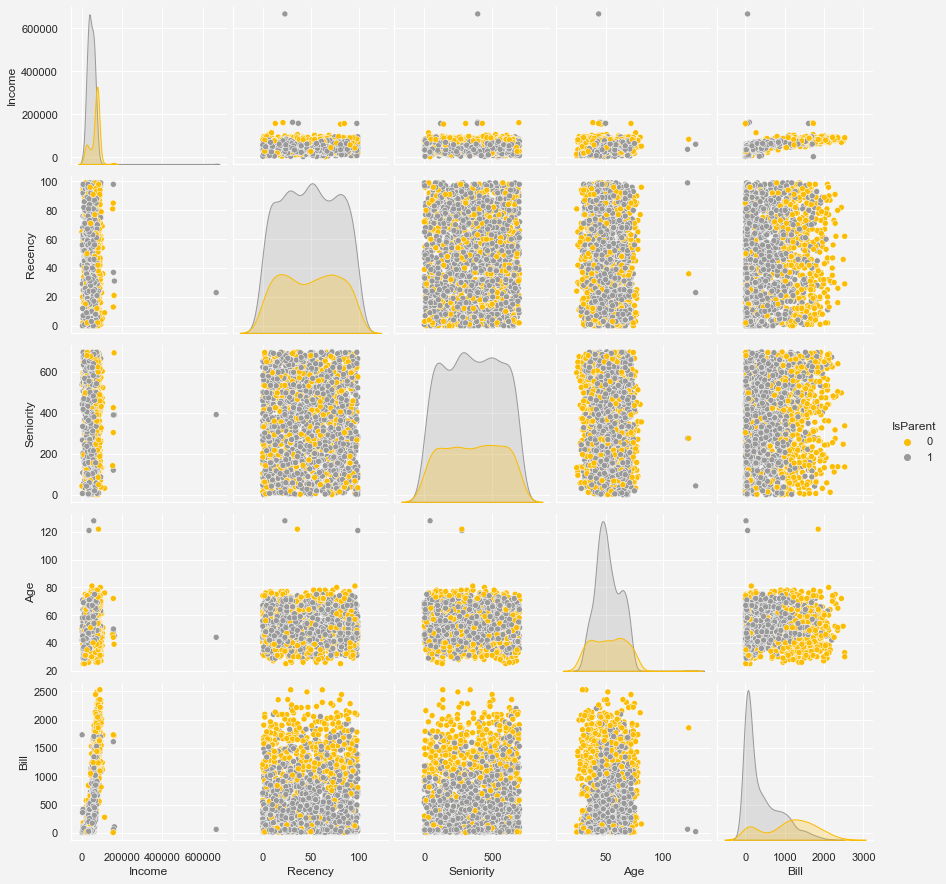

In [38]:
# Checking outliers
colsplot = ["Income", "Recency", "Seniority", "Age", "Bill", "IsParent"]

colors = ['#fbbc04', '#999999']

sns.set(rc={"axes.facecolor":"#F3F3F3","figure.facecolor":"#F3F3F3"})
sns.pairplot(data[colsplot], hue= "IsParent",palette= (colors))


In [39]:
# Fixing outliers
df = data[
        (data["Age"]<90) &
        (data["Income"]<600000)
    ].copy()


Now that the data is cleaned from outliers and weird values, it is time for preprocessing the dataset for feeding the models.

## 3.3 Preprocessing stage

Before feeding the models with our data we need to preprocess a little bit the current dataset. The preprocessing stage has most of the time the **following steps**:

1. **Label encoding**: To encode categorical features, that means from string to a cardinal number for representing the category.
2. **Scaling features**: Scaled data makes it easy for a model to learn and understand the problem as the algorithms can calculate the distance between the data points easier for making better inferences out of the data.
3. **Dimensionality Reduction** As the current dataset have too many fators for doing the classification, algorithms might struggle for doing the calculations. There are several features that are correlated and therefore they are redundant. Using dimensionality reduction we'll keep just the features that are worth to consider for the calculation.

In [40]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler

LE = LabelEncoder()

df['Education'] = df[['Education']].apply(LE.fit_transform)
le_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(le_name_mapping)

df['Partner'] = df[['Partner']].apply(LE.fit_transform)

le_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(le_name_mapping)

for i in range(1,6):
    col = 'AcceptedCmp'+ str(i)
    df[col] = df[[col]].apply(LE.fit_transform)



list(LE.classes_)
list(LE.inverse_transform([0,1]))


{'Graduate': 0, 'NoGraduate': 1}
{0: 0, 1: 1}


[False, True]

In [41]:
# Standard Scaler
data_scaler = df.drop(mkt_cols, axis=1)
SC = StandardScaler()
SC.fit(data_scaler)
SC_values = SC.transform(data_scaler)
SC_header = data_scaler.columns
SC_df = pd.DataFrame(SC_values, columns=SC_header)
SC_df.head(2)

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Seniority,Partner,Children,FamilySize,IsParent,Bill
0,-0.358569,0.287105,0.310353,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,1.527721,-1.349603,-1.264598,-1.758359,-1.581139,1.676245
1,-0.358569,-0.260882,-0.380813,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-1.189011,-1.349603,1.404572,0.449070,0.632456,-0.963297


### The dimensionality reduction with PCA

As mentioned before, one of the main steps in the preprocessing is to reduce the number of features of the dataset in order to keep just the features that are not redundant. With this step we are aiming to:
1. To reduce the dataset size
2. To increase interpretability and features managing
3. To minimize the loss of information

 In order to do this I will use one of the main algorithms that allows to reduce datasets in an easy way, the *Principal Component Analysis or PCA*.

 For interpretability reasons, I will reduce the dimensionality to 3 features.

In [42]:
from sklearn.decomposition import PCA

# Dimensionality Reduction
COMP = 3
PCA = PCA(n_components=COMP)
PCA.fit(SC_df)
PCA_values = PCA.transform(SC_df)
PCA_header = ['col_'+str(i+1) for i in range(0,COMP)]

PCA_df = pd.DataFrame(PCA_values, columns=PCA_header)
PCA_df.head(2)


x = PCA_df["col_1"]
y = PCA_df["col_2"]
z = PCA_df["col_3"]

# 4. Clustering the data

Once that the preprocessing stage is finished, we can feed our data to the algorithm. In this case, as we don't have labels in our data to predict, I will use Agglomerative Clustering algorithm for grouping the customers. This is a hierarchical clustering method that involves merging examples until the desired number of clusters is achieved.

In order to do that, it is necessary to perform several steps:
1. To find the number of clusters using the Elbow Method
2. To apply the Agglomerative Clustering algorithm
3. Plot the clusters in order to analyse them

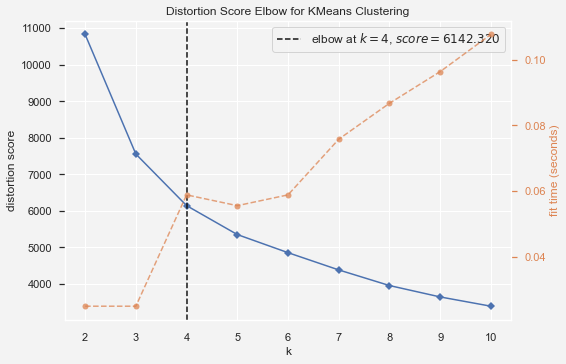

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# Elbow Method
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(PCA_df)
elbow.show()

We can see that the elbow is in 4 clusters.

In [44]:
# Agglomerative Clustering
# We make a copy of the dataset without preprocessing for plotting next values with new clusters

df_cluster = df.copy() 
pred = PCA_df.copy()

ac = AgglomerativeClustering(n_clusters=4)
yhat = ac.fit_predict(pred)

df_cluster['cluster'] = yhat

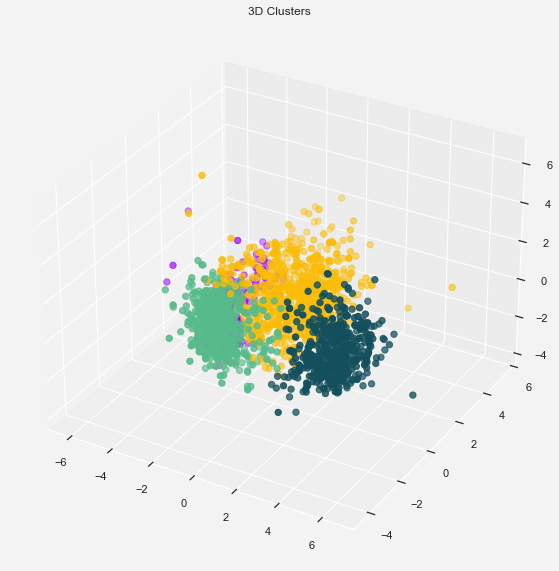

In [45]:
# Visualization
from matplotlib import colors

fig = plt.figure(figsize = (10,10))
ax = plt.subplot(projection='3d')
cmap = colors.ListedColormap(["#fbbc04", "#999999", "#134f5c", "#f5959c", "#57bb8a", "#9900ff"])

ax.scatter(x, y, z, s=40, c=df_cluster["cluster"], marker='o', cmap = cmap )
ax.set_title("3D Clusters")
plt.show()

sns.set_style('white')
sns.set_theme()

# 5. Model Evaluation

As this is an unsupervised algorithm and we don't have labels for evaluating the results, it is necessary to understand the output and analysing the cluster in order to check that the patterns make sense.

There are several approaches for doing that:
1. Clustering distribution + boxplot
2. Clustering against the main interesting feature: Income and bill and also age and bill

,cluster,customers
0,0,796
1,2,695
2,1,489
3,3,232


Text(0.5, 1.0, 'Clusters boxplot')

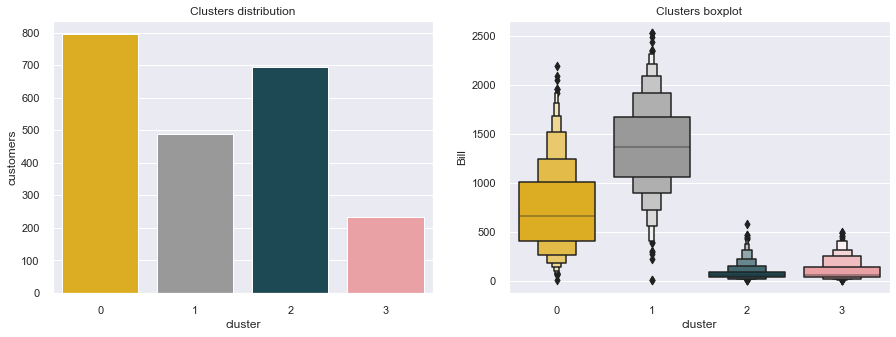

In [46]:
# Check clustering distribution, 4 clusters -> 4 colors
clusters = df_cluster.cluster.value_counts().reset_index().rename(columns={'index':'cluster', 'cluster':'customers'})
display(clusters)

colors = ["#fbbc04", "#999999", "#134f5c", "#f5959c"]

fig, axs = plt.subplots(ncols=2, figsize = (15,5))

ax1 = sns.barplot(x='cluster', y='customers', data=clusters, palette=colors,  ax=axs[0])
ax1.set_title('Clusters distribution')

ax2 = sns.boxenplot(x=df_cluster["cluster"], y=df_cluster["Bill"], palette=colors,  ax=axs[1])
ax2.set_title('Clusters boxplot')

The different groups clustered when we plot `Bill` vs `Income` are:
- Group 0 (yellow): High Bill / Avg Income
- Group 1 (grey): High Bill / High Income
- Group 2 (blue): Low Bill / Low Income
- Group 3 (pink): Low Bill / Avg(almost high) Income

The different groups clustered when we plot `Income` vs `Age` are:
- Group 0 (yellow): Above 40-50 / Avg-high Income
- Group 1 (grey): All ages / Customers with high income
- Group 2 (blue): Below 40-50 / Low Income
- Group 3 (pink): Above 50 / Avg-Low Income

Text(0.5, 1.0, 'Bill vs Income per cluster')

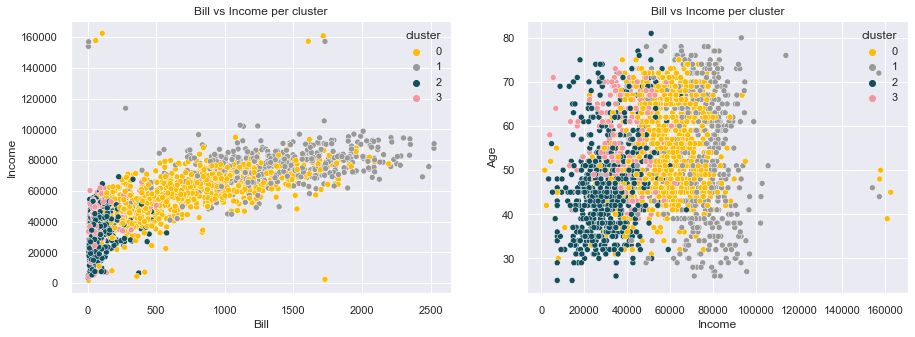

In [47]:
fig, axs = plt.subplots(ncols=2, figsize = (15,5))

ax1 = sns.scatterplot(x='Bill', y='Income', data=df_cluster, hue=df_cluster['cluster'], palette=colors, ax=axs[0])
ax1.set_title('Bill vs Income per cluster')

ax2 = sns.scatterplot(x='Income', y='Age', data=df_cluster, hue=df_cluster['cluster'], palette=colors, ax=axs[1])
ax2.set_title('Bill vs Income per cluster')

If we take a look just the the main clusters 0 and 1 it is possible to see better the difference between the 2 types of main customers

Text(0.5, 1.0, 'Bill vs Income. Cluster 0 and 1')

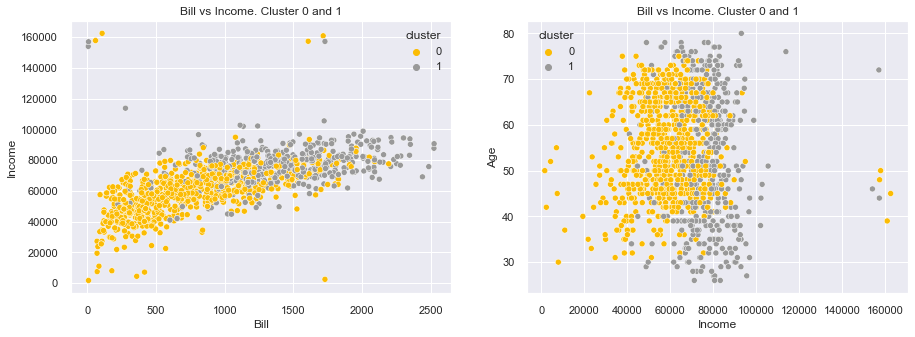

In [48]:
df_cluster_main = df_cluster[df_cluster.cluster.isin([0,1])].copy()
fig, axs = plt.subplots(ncols=2, figsize = (15,5))

ax1 = sns.scatterplot(x='Bill', y='Income', data=df_cluster_main, hue=df_cluster_main['cluster'], palette=colors[0:2], ax=axs[0])
ax1.set_title('Bill vs Income. Cluster 0 and 1')

ax2 = sns.scatterplot(x='Income', y='Age', data=df_cluster_main, hue=df_cluster_main['cluster'], palette=colors[0:2], ax=axs[1])
ax2.set_title('Bill vs Income. Cluster 0 and 1')

# 6. Marketing campaigns - Cluster Analysis

Now that we have identified the clusters, let's take a look at the previous campaigns using the `AcceptedCmpX` columns (being X the number of the campaign).

- It is possible to see that the marketing campagins aren't too effective. Most of the customers just accepted 0 campaigns.
- Also, althogh there are 5 different campaigns, no one has reached the fifth one.
- It is clear that it is necessary to put some course of action in order to improve the performance of the campaigns.


Text(0.5, 1.0, 'Campaigns accepted per cluster')

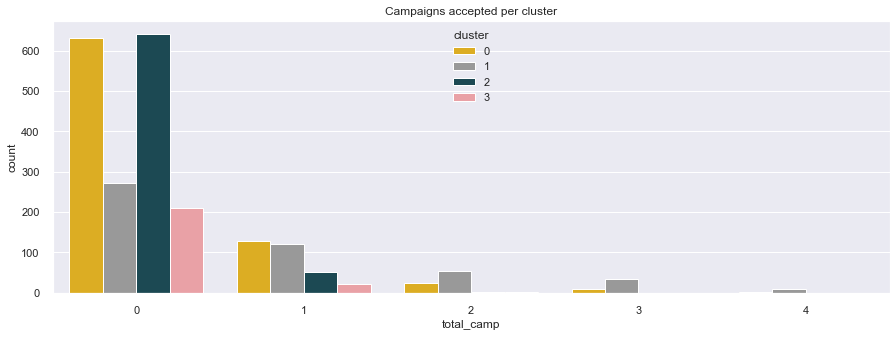

In [49]:
df_cluster['total_camp'] = df_cluster["AcceptedCmp1"] + df_cluster["AcceptedCmp2"] + df_cluster["AcceptedCmp3"] + df_cluster["AcceptedCmp4"] + df_cluster["AcceptedCmp5"]


plt.figure(figsize = (15,5))

ax1 = sns.countplot(x=df_cluster["total_camp"], hue=df_cluster['cluster'], palette=colors)
ax1.set_title('Campaigns accepted per cluster')

# 7. Generate ICPs

Last step of our research is to create several profiles using the clustering results. This will help us to identify better the customers' habit for buying in the store. The **goal here is to find out which is our top profile customer** in order to **maximize our sellings** or in other words, the money spent per customer.

In order to do that, let's take a look at the main descriptive attributes

In [50]:
desc = [ "Children", "Seniority", "Age", "FamilySize", "IsParent", "Education", "Partner"]

<Figure size 576x396 with 0 Axes>

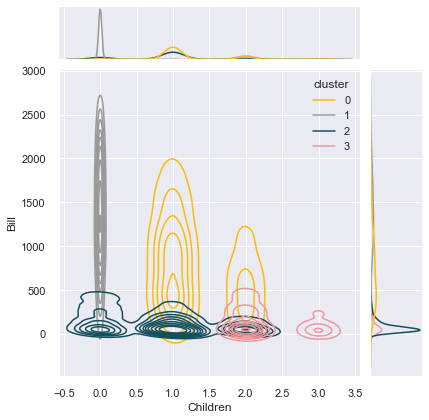

<Figure size 576x396 with 0 Axes>

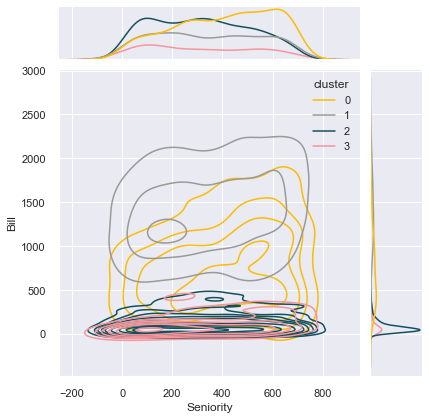

<Figure size 576x396 with 0 Axes>

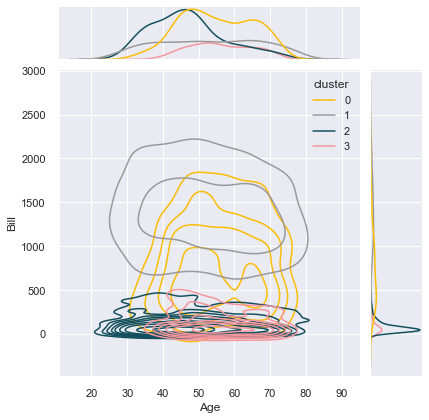

<Figure size 576x396 with 0 Axes>

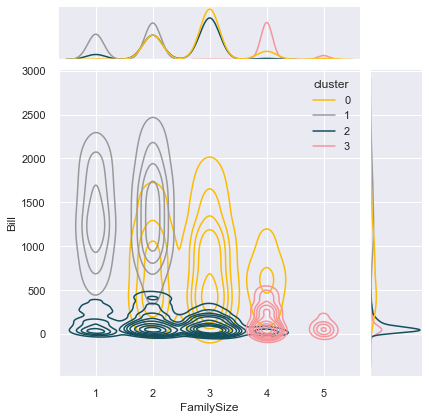

c:\Users\Juan\anaconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 576x396 with 0 Axes>

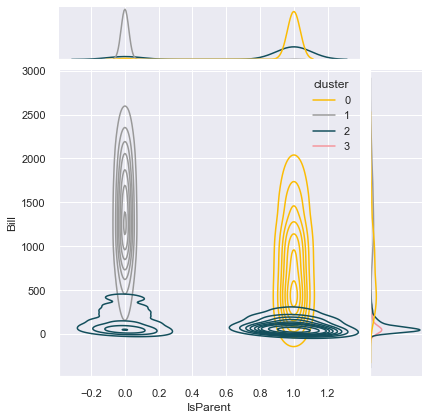

<Figure size 576x396 with 0 Axes>

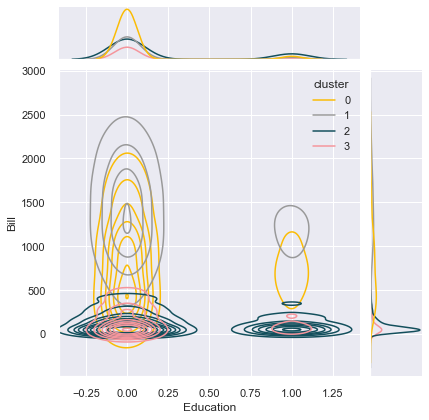

<Figure size 576x396 with 0 Axes>

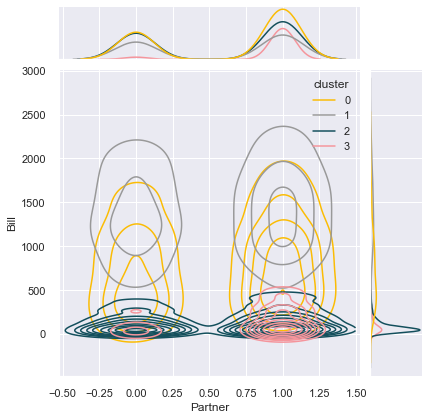

In [51]:
for i in desc:
    plt.figure()
    sns.jointplot(x=df_cluster[i], y=df_cluster["Bill"], hue =df_cluster["cluster"], kind="kde", palette=colors)
    plt.show()